# IA Notebook #4 | Programando Red Neuronal desde Cero

Este es un notebook eleaborado originalmente por Carlos Santana Vega y comentado por Luis Arturo Cruz Cruz. Puedes consultar la fuente original en: https://www.youtube.com/watch?v=W8AeOXa_FqU

El objetivo de este ejercicio es clasificar un una clase , un dataset de puntos distribuidos de forma circular de otro dataset de puntos. Este problema de clasificación solo puede ser resuelto con una curva cerrada.

In [ ]:
#Librerias necesarias para este proyecto
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

#La librería SK Learn es requerida para crear los datasets.
from sklearn.datasets import make_circles

In [ ]:
make_circles?
#Amable recordatorio: con ? puedes acceder a la documentación del método

In [ ]:
#Inicializar las variables n y p.
#Donde n es el tamaño dl dataset y p es el número de atributos que contiene un punto. 
n = 500 #El número de registros
p = 2 #¿Cuantas características tengo en cada dato?

## 1. Definimos el dataset que queremos clasificar.

A continuación, vamos a inicializar el dataset de puntos que vamos a clasificar. La variable X son las tuplas que contienen las coordenadas en el plano de cada punto, la variable Y es un vector que define a que clase (dos clases, 0 o 1) pertenece cada punto.**bold text**

(500, 1)


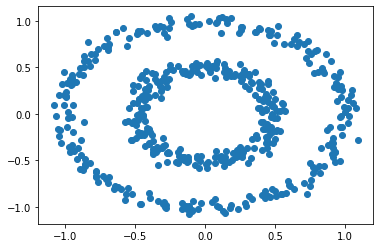

In [ ]:
X, Y = make_circles(n_samples=n, factor=0.5, noise = 0.05)
#el parámetro factor separa las dispersiones de puntos.
#el parámetro noise es el indice de disperción de los puntos en el plano.

Y = Y[:, np.newaxis] #Esta linea cambia la estructura del vector de salida.
print(Y.shape)

plt.scatter(X[:, 0],X[:, 1] ) #La imagen muestra las dispersiones de ambas clases.
plt.show()

A continuación, vamos a visualizar los puntos, representando las clases en dos colores (0 para la clase "blue", 1 para la clase "red")

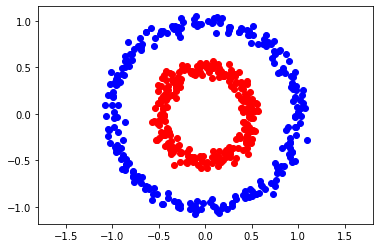

In [ ]:
plt.scatter(X[Y[:, 0] == 0, 0],X[Y[:, 0] == 0, 1], c="blue" )
plt.scatter(X[Y[:, 0] == 1, 0],X[Y[:, 0] == 1, 1], c="red" )
plt.axis("equal")
plt.show()

A continuación, crearemos una clase (en el contexto del paradigma de POO) que contenga los atributos de una capa de neuronas. Esta estructura contiene el número de conexiones, el número de neuronas, la función de activación, el vector de sesgos y la matriz de pesos. Tanto el vector de sesgos como la matriz de pesos contienen valores al azar normalizados (valores aleatorios entre -1 y 1).

Pregunta 1: Entiendo porque los datos del vector de sesgos y de la matriz de pesos deben ser aleatorios, pero ¿Por qué deben ser normalizados y en un rango entre -1 y 1?

##2. Definimos la estructura de la red neuronal.

In [ ]:
#Clase de la capa de la red

class neural_layer():
  def __init__(self, n_conn, n_neur, act_f):
    self.act_f = act_f
        
    self.b = np.random.rand(1, n_neur)*2-1
    self.W = np.random.rand(n_conn, n_neur)*2-1

En la siguiente celda definiremos la función de activación sigmoide y su derivada, ambas funciones están en una tupla, donde la primer componente de la tupla es la función y la segunda componente es su derivada.

$$\sigma (x)=\frac{1}{1+e^{-x}}$$

$${\sigma}'(x)=x(1-x)$$

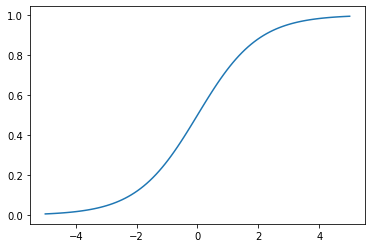

In [ ]:
#Funiones de activación

sigm = (lambda x : 1/(1+np.e**(-x)), lambda x : x*(1-x))

_x = np.linspace(-5,5, 100)
plt.plot(_x, sigm[0](_x))

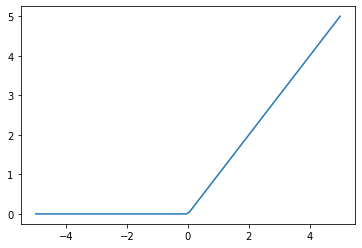

In [ ]:
#Esta función ReLu es solo demostrativa, no se utilizará en el proyecto

ReLu = lambda x : np.maximum(0,x)
_x = np.linspace(-5,5, 100)
plt.plot(_x, ReLu(_x))

Es necesario notar, que la estructura ```neural_layer``` requiere de tres argumentos (número de conexiones a la entrada, número de neuronas en la capa, función de activación característica de la capa). Con la ayuda del vector ```topology```, característico de la forma de toda la red, podremos automatizar la construcción de toda la red.

In [ ]:
l0 = neural_layer(n_conn = p, n_neur = 4 , act_f = sigm) #capa de entrada
l1 = neural_layer(n_conn = 4, n_neur = 8 , act_f = sigm) #1er capa oculta
#···
topology = [p, 4, 8, 1]

La función ```create_nn``` requiere dos argumentos:

1.   El vector ```topology``` característico de la red, cada componente representa el número de neuronas por capa.

2.   La función de activación ```act_f``` , que para este proyecto será la misma en todas las capas. 



In [ ]:
def create_nn(topology, act_f):
  nn = []
    
  for l, layer in enumerate(topology[:-1]):
    nn.append(neural_layer(topology[l], topology[l+1] , act_f))
    
  return nn

In [ ]:
create_nn(topology, sigm)

## 3. Definimos la función de entrenamiento de la red

En la siguiente celda se puede observar, que la variable ```l2_cost``` se compone de una tupla de dos funciones lambda (sumatorias), donde la primera componente es la función de coste y la segunda componente es la derivada de la función de coste.

La función de coste se define de la siguiente manera (Error cuadrático medio):

$$MSE = \frac{1}{n}\sum_{i = 1}^{n}\left ( Y_{i} - \hat{Y}_{i} \right )^{2}$$

La derivada de la función de coste es la siguiente:

$$D(MSE) = \sum_{i = 1}^{n}\left ( Y_{i} - \hat{Y}_{i} \right )$$


In [ ]:
neural_net = create_nn(topology, sigm)
l2_cost = (lambda Yp, Yr: np.mean((Yp - Yr)**2), lambda Yp, Yr: (Yp - Yr))

En este punto del proyecto la red neuronal ya está construida, pero no ha sido entrenada ni ajustada.

La función de entrenamiento contempla los siguientes pasos:

 1. Propagación hacia adelante.
 2. Comparar resultados obtenidos con los esperados.
 3. Propagación hacia atras.

In [ ]:
#Función de entrenamiento
def train(neural_net, X, Y, f_cost,lr=0.5,train=True):
  out=[(None,X)] # En este array guarda los pares de z y a [(z0,a0),(z1,a1),...]
  
  #1. Propagación hacia adelante.
  for l, layer in enumerate(neural_net):
    
    z = np.dot(out[-1][1],neural_net[l].W) + neural_net[l].b
    a = neural_net[l].act_f[0](z)
   
    out.append((z,a))

  #2. Backpropagation and Gradient descent
  
  if train:
    delta=[]
    
    for l in reversed(range(0,len(neural_net))):
      z=out[l+1][0]
      a=out[l+1][1]
      
      #Si estamos en la ultima capa
      if l == len(neural_net) - 1:
        delta.insert(0, f_cost[1](a, Y) * neural_net[l].act_f[1](a))
      #Calculamos delta en las capas previas
      else:
        delta.insert(0,np.dot(delta[0],aux_w.T) * neural_net[l].act_f[1](a)) 
          
      aux_w=neural_net[l].W 
      #Lo guardamos en una variable auxiliar para poder modificar los valores al mismo tiempo usando el Gradiente descendente
          
      #Gradient Descent : Ajuste de la matriz de pesos y el valor del vector sesgo.
      neural_net[l].b = neural_net[l].b - lr * np.mean(delta[0], axis=0, keepdims=True)
      neural_net[l].W = neural_net[l].W - np.dot(out[l][1].T,delta[0])*lr
          
  return out[-1][1]

## 4. Enfrentamos a la red con los datos y presentamos resultados.

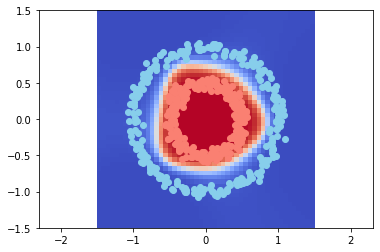

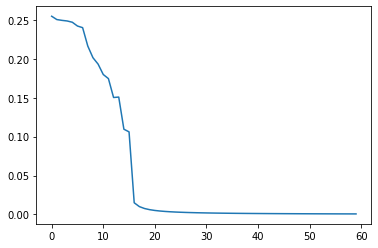

In [ ]:
import time
from IPython.display import clear_output

neural_n = create_nn(topology, sigm)
loss = []

for i in range(1500):
    
  #Entrenamos la red:
  pY = train(neural_n, X, Y, l2_cost, lr = 0.05)

  if i%25 == 0:
  
    loss.append(l2_cost[0](pY,Y))
    res = 50
    _x0 = np.linspace(-1.5, 1.5, res)
    _x1 = np.linspace(-1.5, 1.5, res)
        
    _Y = np.zeros((res, res))
        
    for i0, x0 in enumerate(_x0):
      for i1, x1 in enumerate(_x1):
        _Y[i0, i1] = train(neural_n, np.array([[x0,x1]]), Y, l2_cost,train=False)[0][0]

    #Visualizamos los resultados del entrenamiento.

    plt.pcolormesh(_x0, _x1, _Y, cmap = "coolwarm")
    plt.axis("equal")

    plt.scatter(X[Y[:,0] == 0, 0], X[Y[:,0] == 0, 1], c = "skyblue" )
    plt.scatter(X[Y[:,0] == 1, 0], X[Y[:,0] == 1, 1], c = "salmon" )

    clear_output(wait = True)
    plt.show()
    plt.plot(range(len(loss)), loss)
    plt.show()
    time.sleep(0.5)